# Projeto de Machine Learning

*Aluno: Joaquim Chianca* 

## Treinamento de um modelo aplicado ao contexto de basquete

A ideia desse projeto é responder a seguinte pergunta motivadora: **Dado um certo jogador arbitrário X da NBA, ele marcará mais ou menos pontos do que Y na próxima partida?**, sendo Y um limite de pontos (no formato Y.5, por exemplo, 26.5 ou 18.5).

## Metodologia

Por se tratar de um problema de classificação (o jogador marcará mais pontos - grupo A - ou menos pontos - grupo B - que uma determinada quantidade?), logo nesse estudo serão utilizados apenas algoritmos de classificação no treino dos modelos.

Nesse Jupyter Notebook, vamos usar um pouco da experimentação para descobrir qual é o melhor algoritmo para treinamento de modelos. O estudo aborda os seguintes modelos:

   1. **Algoritmo kNN**: É um algoritmo de aprendizado de máquina supervisionado que não faz suposições sobre a distribuição dos dados. Baseia-se na ideia de que pontos de dados semelhantes estão próximos um do outro. O KNN usa a proximidade para classificar ou prever o valor de um novo ponto de dados, considerando os 'k' pontos mais próximos
   2. **Árvores de Decisão:** Este é um modelo preditivo que utiliza uma estrutura de árvore ou lógica condicional (if-else) para tomar decisões. Começando pela raiz da árvore, cada nível representa uma decisão que divide os dados com base em um critério específico, conduzindo a folhas que representam as classificações ou previsões finais.
   3. **Random Forest**: É um ensemble de árvores de decisão. Funciona treinando múltiplas árvores de decisão com subconjuntos dos dados de treinamento e então agregando suas previsões. Esse método melhora a precisão e controla o overfitting, sendo eficaz para grandes conjuntos de dados.
   4. **GBM (Gradient Boosting Machine)**: É uma técnica de boosting que constrói modelos de forma sequencial, onde cada novo modelo tenta corrigir os erros do modelo anterior. Baseia-se em otimização gradiente, ajustando-se iterativamente para minimizar uma função de perda.
    
A experimentação determina qual modelo é mais preciso, seguindo uma métrica de acurácia, a qual calcula a proporção de previsões corretas em relação ao total de previsões feitas.

Por fim, é feita uma tentativa de combinar os vários modelos treinados num processo de criação de Ensemble (combinação de vários modelos), usando o `VotingClassifier` da biblioteca `sklearn`. O `VotingClassifier` é um modelo que combina as previsões de diversos modelos para determinar a saída final com base na classe que mais frequentemente é escolhida pelos modelos individuais.

## Resultado

O modelo com maior acurácia, será utilizado num programa em Python capaz de responder à pergunta motivadora. Como o jogador e a quantidade de pontos são variáveis, que serão definidas pelo usuário, **o jogador LeBron James com um limite de 26.5 pontos serão utilizados como exemplo.**

# Leitura e tratamento do dataset

Bloco onde foi feito carregamento dos dados a partir do dataset obtido por meio [Kaggle](https://www.kaggle.com/datasets/eduardopalmieri/5555555). Foi utilizada a biblioteca `pandas`.

A limpeza dos dados seguiu a seguinte lógica:
 - Remoção de jogadores que jogaram menos de 16 jogos, porque provavelmente estão lesionados ou são jogadores com pouca minutagem. Uma temporada regular de basquete (sem contar a fase de mata-mata) possui 82 jogos.
 - Remoção de colunas irrelevantes, como data do jogo, time do jogador, porque não impactam na predição de quantos pontos ele faz durante as partidas.

In [63]:
import pandas as pd

data = pd.read_csv('database_csv.csv')

selected_columns = ['Player', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 
                    'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                    'BLK', 'TOV', 'PF', 'PTS']

new_data = data[selected_columns]


games_per_player = new_data['Player'].value_counts()
eligible_players = games_per_player[games_per_player >= 16].index

filtered_data = new_data[new_data['Player'].isin(eligible_players)]

print(filtered_data.head()) # dataset filtrado

# Verificar valores faltantes
missing_values = filtered_data.isnull().sum()
print("\nValores faltantes:")
print(missing_values) # não tem valores faltantes
print(data.head()) #valores do dataset original
print(data.info())
print(filtered_data.info())

         Player     MP  FG  FGA    FG%  3P  3PA    3P%  FT  FTA  FT%  ORB  \
0  Nikola Jokić  36.27  12   22  0.545   3    5  0.600   2    4  0.5    3   
1  Devin Booker  36.97  13   21  0.619   3    8  0.375   3    3  1.0    1   
2  LeBron James  29.00  10   16  0.625   1    4  0.250   0    1  0.0    1   
3  Aaron Gordon  34.98   7   11  0.636   1    2  0.500   0    0  0.0    2   
4  Jamal Murray  34.25   8   13  0.615   3    5  0.600   2    2  1.0    0   

   DRB  TRB  AST  STL  BLK  TOV  PF  PTS  
0   10   13   11    1    1    2   2   29  
1    5    6    8    1    0    6   4   32  
2    7    8    5    1    0    0   1   21  
3    5    7    5    2    1    0   0   15  
4    2    2    6    0    1    1   3   21  

Valores faltantes:
Player    0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64
      

# Treinamento do modelo a partir do algoritmo k-NN

Como dito antes, iremos analisar apenas os dados do jogador LeBron James. O programa em Python se encarrega de receber parâmetros para predição da pontuação de outros jogadores.

Então, nesse exemplo, a pergunta motivadora é **O LeBron James consegue passar de 26.5 pontos na sua próxima partida, baseado nos dados de partidas anteriores?**

## Metodologia

Vamos separar os dados em 70% para treinamento e 30% para teste, mantendo um `random_state=42`, visando hegemonia na separação dos dados independente ambiente de execução. Além disso, vamos selecionar apenas as colunas referentes às estatísticas desse jogador.

O treinamento abordou diferentes valores de k, assim como diferentes métricas (euclidiana e manhattan) para treinamentos, uma vez que essa variância de hiperparâmetros pode trazer acurácias diferentes. Os pesos estão marcados com `distance`, porque no basquete é comum que um jogador mantenha uma boa sequência de jogos, então os vizinhos mais próximos possuem maior peso.

Por fim, serão plotados gráficos em linha, comparando os dois modelos treinados, um para a métrica euclidiana e outro para métrica Manhattan.


Acurácia (Euclidean) (KNN com k=3): 79.17% 
Acurácia (Manhattan) (KNN com k=3): 79.17% 

Acurácia (Euclidean) (KNN com k=5): 83.33% 
Acurácia (Manhattan) (KNN com k=5): 83.33% 

Acurácia (Euclidean) (KNN com k=7): 87.50% 

Relatório de Classificação para KNN Euclidean com k=7:
              precision    recall  f1-score   support

       False       0.84      1.00      0.91        16
        True       1.00      0.62      0.77         8

    accuracy                           0.88        24
   macro avg       0.92      0.81      0.84        24
weighted avg       0.89      0.88      0.87        24

Acurácia (Manhattan) (KNN com k=7): 83.33% 

Acurácia (Euclidean) (KNN com k=9): 83.33% 
Acurácia (Manhattan) (KNN com k=9): 83.33% 

Acurácia (Euclidean) (KNN com k=11): 83.33% 
Acurácia (Manhattan) (KNN com k=11): 79.17% 

Acurácia (Euclidean) (KNN com k=13): 83.33% 
Acurácia (Manhattan) (KNN com k=13): 87.50% 

Relatório de Classificação para KNN Manhattan com k=13:
              precisio

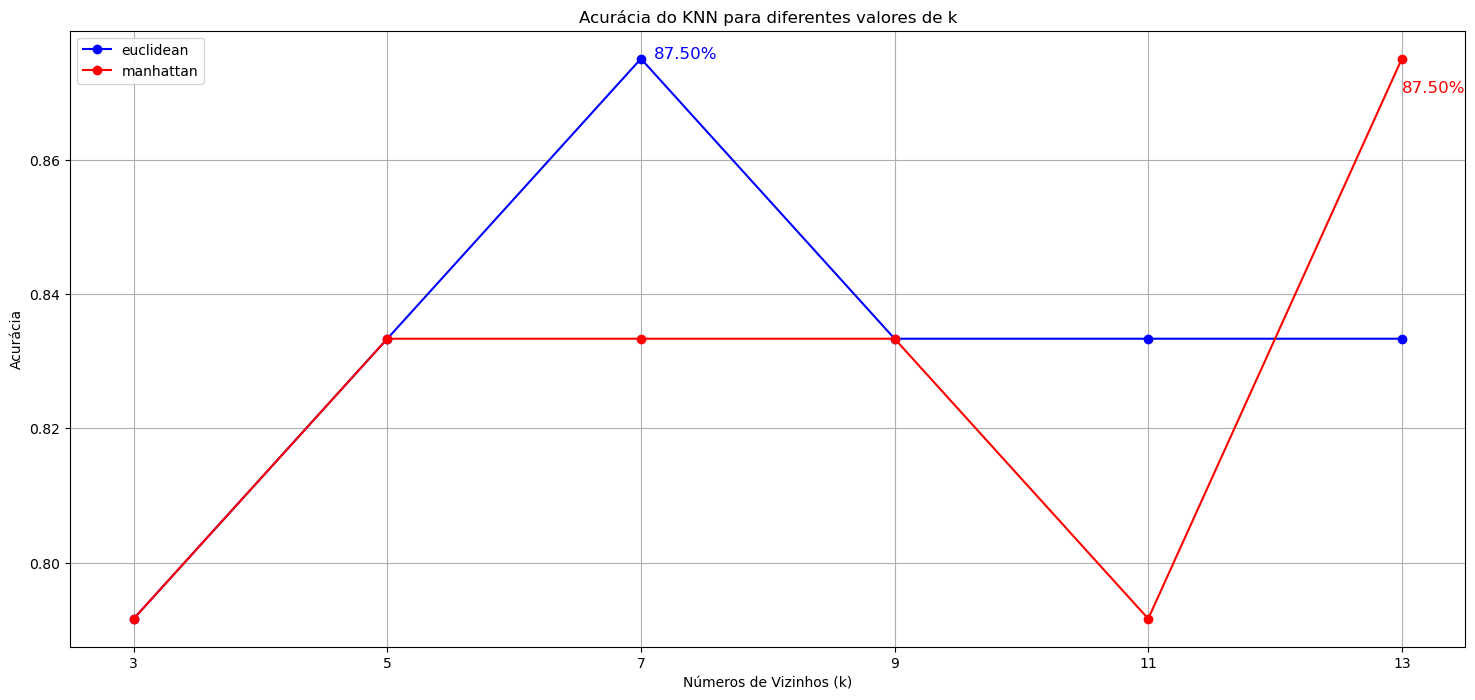

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Criando coluna com valor booleano para saber se passou de 26.5 (true) ou não (false)
limit_points = 26.5

lebron_data = filtered_data[filtered_data['Player'] == 'LeBron James'].copy()
lebron_data.loc[:, 'Above_Limit'] = lebron_data['PTS'] > limit_points

features = ['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 
            'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 
            'STL', 'BLK', 'TOV', 'PF']

X = lebron_data[features]
y = lebron_data['Above_Limit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k_values = [3, 5, 7, 9, 11, 13]
accuracies_euclidean = []
accuracies_manhattan = []

for k in k_values:
    knn_model_euclidean = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn_model_manhattan = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='manhattan')
    knn_model_euclidean.fit(X_train, y_train)
    knn_model_manhattan.fit(X_train, y_train)
    y_pred_knn_euclidean = knn_model_euclidean.predict(X_test)
    y_pred_knn_manhattan = knn_model_manhattan.predict(X_test)
    accuracy_knn_euclidean = accuracy_score(y_test, y_pred_knn_euclidean)
    accuracy_knn_manhattan = accuracy_score(y_test, y_pred_knn_manhattan)
    accuracies_euclidean.append(accuracy_knn_euclidean)
    accuracies_manhattan.append(accuracy_knn_manhattan)
    print(f"\nAcurácia (Euclidean) (KNN com k={k}): {(accuracy_knn_euclidean * 100):.2f}% ")
    if k == 7:
        print(f"Relatório de Classificação para KNN Euclidean com k={k}:")
        print(classification_report(y_test, y_pred_knn_euclidean))
    print(f"Acurácia (Manhattan) (KNN com k={k}): {(accuracy_knn_manhattan * 100):.2f}% ")
    
    if k == 13:
        print(f"Relatório de Classificação para KNN Manhattan com k={k}:")
        print(classification_report(y_test, y_pred_knn_manhattan))

    
plt.figure(figsize=(18, 8))
plt.plot(k_values, accuracies_euclidean, marker='o', linestyle='-', color='b')
plt.plot(k_values, accuracies_manhattan, marker='o', linestyle='-', color='r')
plt.title('Acurácia do KNN para diferentes valores de k')
plt.xlabel("Números de Vizinhos (k)")
plt.ylabel('Acurácia')
plt.xticks(ticks=k_values)
plt.grid(True)
plt.legend(['euclidean', 'manhattan'], loc="upper left")

for i, (accuracy_euclidean, accuracy_manhattan) in enumerate(zip(accuracies_euclidean, accuracies_manhattan)):
    if k_values[i] in [7]:
        plt.text(k_values[i] + 0.1, accuracies_euclidean[i], f"{(accuracies_euclidean[i] * 100):.2f}%", fontsize=12, ha='left', color='blue')
    elif k_values[i] in [13]:
        plt.text(k_values[i], accuracies_manhattan[i] - 0.005, f"{(accuracies_manhattan[i] * 100):.2f}%", fontsize=12, ha='left', color='red')

plt.show()

## Resultado kNN

Note que a maior acurácia do modelo euclidiano foi de 87,5%, assim como o modelo de Manhattan, embora os dois usem valores de k diferentes. 

Mesmo assim, o kNN é considerado um algoritmo simples, talvez uma análise mais granular consiga extrair o melhor de um modelo de aprendizado de máquina.

# Treinamento com algoritmo de árvores de decisão

## Metodologia

A partir de agora, vou utilizar os sets de dados já separados, utilizando as mesmas constantes de exemplo ("LeBron James", 26.5 pontos). **Serão criados 3 modelos**: o primeiro com tendências gerais e mais simples, o segundo com foco em captura de detalhes e consistência (seguindo a lógica de ser comum jogadores engatarem uma boa sequência de jogos) e o terceiro visando detalhar ainda mais a análise do 2° modelo.

Essa variância é necessária para experimentação e é feita a partir da mudança dos hiperparâmetros, como já mencionado.

Por fim, serão plotados gráficos de barra para comparação das acurácias dos modelos treinados. Além disso, um `classification_report` com métricas mais detalhadas sobre a performance do modelo na predição dos dados.

Acurácia (Árvore de Decisão - Modelo 1): 70.83%
Relatório de Classificação (Árvore de Decisão - Modelo 1):
               precision    recall  f1-score   support

       False       0.80      0.75      0.77        16
        True       0.56      0.62      0.59         8

    accuracy                           0.71        24
   macro avg       0.68      0.69      0.68        24
weighted avg       0.72      0.71      0.71        24


Acurácia (Árvore de Decisão - Modelo 2): 83.33%
Relatório de Classificação (Árvore de Decisão - Modelo 2):
               precision    recall  f1-score   support

       False       1.00      0.75      0.86        16
        True       0.67      1.00      0.80         8

    accuracy                           0.83        24
   macro avg       0.83      0.88      0.83        24
weighted avg       0.89      0.83      0.84        24


Acurácia (Árvore de Decisão - Modelo 3): 83.33%
Relatório de Classificação (Árvore de Decisão - Modelo 3):
               precis

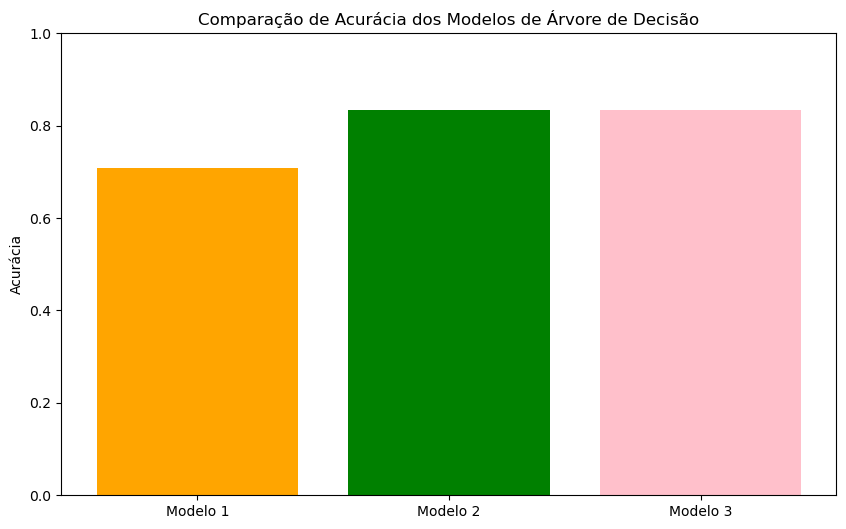

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Modelo 1
dt_model_1 = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

dt_model_1.fit(X_train, y_train)
y_pred_dt_1 = dt_model_1.predict(X_test)
accuracy_dt_1 = accuracy_score(y_test, y_pred_dt_1)
classification_rep_dt_1 = classification_report(y_test, y_pred_dt_1)

print(f"Acurácia (Árvore de Decisão - Modelo 1): {accuracy_dt_1 * 100:.2f}%")
print("Relatório de Classificação (Árvore de Decisão - Modelo 1):\n", classification_rep_dt_1)



# Modelo 2
dt_model_2 = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

dt_model_2.fit(X_train, y_train)
y_pred_dt_2 = dt_model_2.predict(X_test)
accuracy_dt_2 = accuracy_score(y_test, y_pred_dt_2)
classification_rep_dt_2 = classification_report(y_test, y_pred_dt_2)

print(f"\nAcurácia (Árvore de Decisão - Modelo 2): {accuracy_dt_2 * 100:.2f}%")
print("Relatório de Classificação (Árvore de Decisão - Modelo 2):\n", classification_rep_dt_2)


# Modelo 3
dt_model_3 = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

dt_model_3.fit(X_train, y_train)

y_pred_dt_3 = dt_model_3.predict(X_test)
accuracy_dt_3 = accuracy_score(y_test, y_pred_dt_3)
classification_rep_dt_3 = classification_report(y_test, y_pred_dt_3)

print(f"\nAcurácia (Árvore de Decisão - Modelo 3): {accuracy_dt_3 * 100:.2f}%")
print("Relatório de Classificação (Árvore de Decisão - Modelo 3):\n", classification_rep_dt_3)


plt.figure(figsize=(10, 6))
plt.bar(['Modelo 1', 'Modelo 2', 'Modelo 3'], [accuracy_dt_1, accuracy_dt_2, accuracy_dt_3], color=['orange', 'green', 'pink'])
plt.title('Comparação de Acurácia dos Modelos de Árvore de Decisão')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()

## Resultado

Os Modelos 2 e 3 apresentam resultados idênticos, com uma boa capacidade de identificar corretamente os casos True, mas com espaço para melhorar na identificação de todos os casos False sem errar. Isso pode ser indicativo de um modelo que, enquanto evita falsos negativos para a classe True, pode ser demasiadamente conservador ou otimista ao classificar casos como True.

O Modelo 1, enquanto tem uma acurácia geral menor, demonstra uma distribuição mais equilibrada de precisão e recall entre as classes, mas com um desempenho geral inferior aos outros modelos.

# Treinamento dos modelos RandomForest

## Metodologia

Aqui seguiremos a mesma lógica do anterior.

Acurácia (Random Forest - Modelo 1): 91.67%
Relatório de Classificação (Random Forest - Modelo 1):
               precision    recall  f1-score   support

       False       0.89      1.00      0.94        16
        True       1.00      0.75      0.86         8

    accuracy                           0.92        24
   macro avg       0.94      0.88      0.90        24
weighted avg       0.93      0.92      0.91        24


Acurácia (Random Forest - Modelo 2): 95.83%
Relatório de Classificação (Random Forest - Modelo 2):
               precision    recall  f1-score   support

       False       0.94      1.00      0.97        16
        True       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24


Acurácia (Random Forest - Modelo 3): 95.83%
Relatório de Classificação (Random Forest - Modelo 3):
               precision    recall  f1-score 

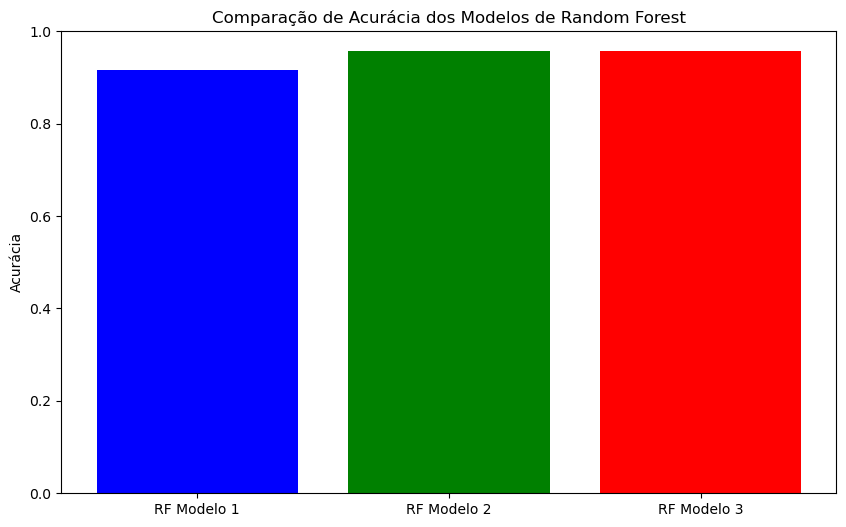

In [68]:
from sklearn.ensemble import RandomForestClassifier

# Modelo 1
rf_model_1 = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

rf_model_1.fit(X_train, y_train)

y_pred_rf_1 = rf_model_1.predict(X_test)
accuracy_rf_1 = accuracy_score(y_test, y_pred_rf_1)
classification_rep_rf_1 = classification_report(y_test, y_pred_rf_1)

print(f"Acurácia (Random Forest - Modelo 1): {accuracy_rf_1 * 100:.2f}%")
print("Relatório de Classificação (Random Forest - Modelo 1):\n", classification_rep_rf_1)


# Modelo 2
rf_model_2 = RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

rf_model_2.fit(X_train, y_train)

y_pred_rf_2 = rf_model_2.predict(X_test)
accuracy_rf_2 = accuracy_score(y_test, y_pred_rf_2)
classification_rep_rf_2 = classification_report(y_test, y_pred_rf_2)

print(f"\nAcurácia (Random Forest - Modelo 2): {accuracy_rf_2 * 100:.2f}%")
print("Relatório de Classificação (Random Forest - Modelo 2):\n", classification_rep_rf_2)


# Modelo 3
rf_model_3 = RandomForestClassifier(
    n_estimators=300,
    criterion='entropy',
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

rf_model_3.fit(X_train, y_train)

y_pred_rf_3 = rf_model_3.predict(X_test)
accuracy_rf_3 = accuracy_score(y_test, y_pred_rf_3)
classification_rep_rf_3 = classification_report(y_test, y_pred_rf_3)

print(f"\nAcurácia (Random Forest - Modelo 3): {accuracy_rf_3 * 100:.2f}%")
print("Relatório de Classificação (Random Forest - Modelo 3):\n", classification_rep_rf_3)

plt.figure(figsize=(10, 6))
plt.bar(['RF Modelo 1', 'RF Modelo 2', 'RF Modelo 3'], [accuracy_rf_1, accuracy_rf_2, accuracy_rf_3], color=['blue', 'green', 'red'])
plt.title('Comparação de Acurácia dos Modelos de Random Forest')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()

**Não suficiente, foi criado outro modelo com mais detalhes ainda**

Acurácia (Random Forest - Modelo 4): 95.83%
Relatório de Classificação (Random Forest - Modelo 4):
               precision    recall  f1-score   support

       False       0.94      1.00      0.97        16
        True       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24



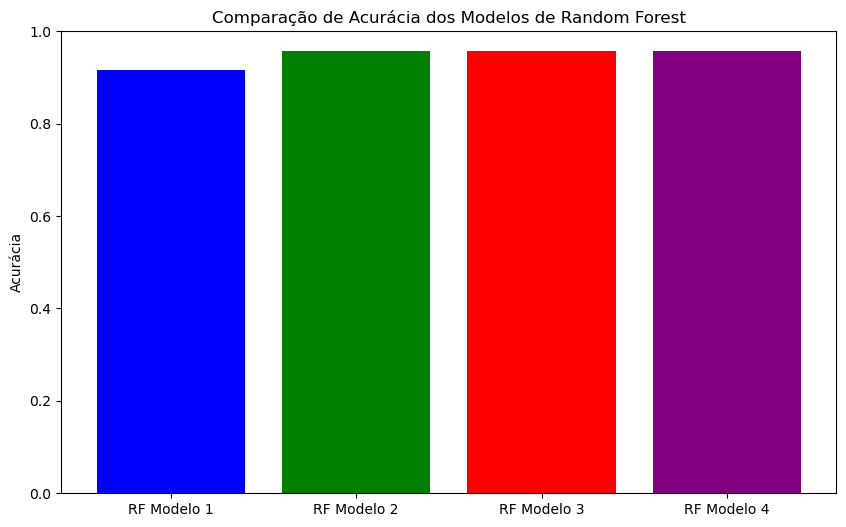

In [54]:
# Modelo 4
rf_model_4 = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

rf_model_4.fit(X_train, y_train)

y_pred_rf_4 = rf_model_4.predict(X_test)
accuracy_rf_4 = accuracy_score(y_test, y_pred_rf_4)
classification_rep_rf_4 = classification_report(y_test, y_pred_rf_4)

print(f"Acurácia (Random Forest - Modelo 4): {accuracy_rf_4 * 100:.2f}%")
print("Relatório de Classificação (Random Forest - Modelo 4):\n", classification_rep_rf_4)

plt.figure(figsize=(10, 6))
plt.bar(['RF Modelo 1', 'RF Modelo 2', 'RF Modelo 3', 'RF Modelo 4'], [accuracy_rf_1, accuracy_rf_2, accuracy_rf_3, accuracy_rf_4], color=['blue', 'green', 'red', 'purple'])
plt.title('Comparação de Acurácia dos Modelos de Random Forest')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()

# Treinamento de modelos a partir do Gradient Boosting Machine (GBM)


Mesma metodologia, com 3 modelos.
A partir desse algoritmo a principal conclusão é que hiperparâmetros mais detalhados geram acurácia semelhante de 95%.

O resultado provavelmente será o mesmo.

Nesse algoritmo, decidi deixar os 3 modelos mais detalhados.

Acurácia (GBM - Modelo 1): 95.83%
Relatório de Classificação (GBM - Modelo 1):
               precision    recall  f1-score   support

       False       0.94      1.00      0.97        16
        True       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24


Acurácia (GBM - Modelo 2): 95.83%
Relatório de Classificação (GBM - Modelo 2):
               precision    recall  f1-score   support

       False       0.94      1.00      0.97        16
        True       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24


Acurácia (GBM - Modelo 3): 95.83%
Relatório de Classificação (GBM - Modelo 3):
               precision    recall  f1-score   support

       False       0.94      1.00      0.97      

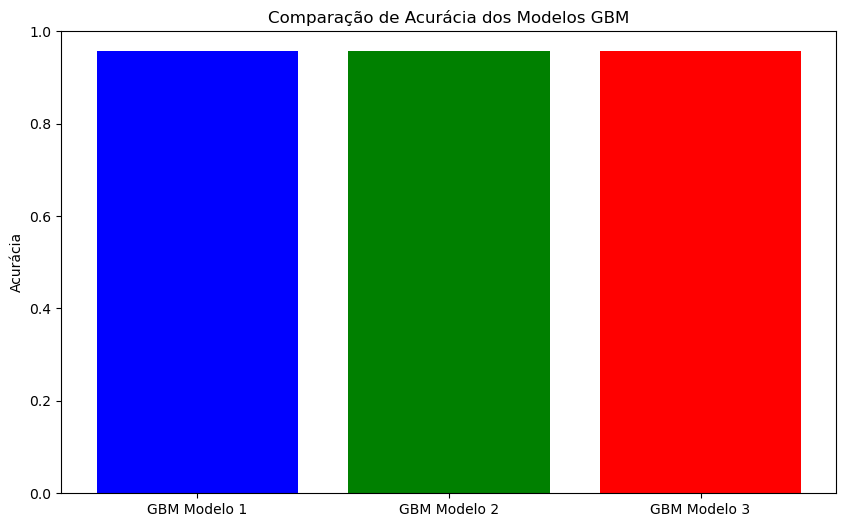

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

# Modelo 1
gbm_model_1 = GradientBoostingClassifier(
    n_estimators=200,
    criterion='friedman_mse',
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

gbm_model_1.fit(X_train, y_train)

y_pred_gbm_1 = gbm_model_1.predict(X_test)
accuracy_gbm_1 = accuracy_score(y_test, y_pred_gbm_1)
classification_rep_gbm_1 = classification_report(y_test, y_pred_gbm_1)

print(f"Acurácia (GBM - Modelo 1): {accuracy_gbm_1 * 100:.2f}%")
print("Relatório de Classificação (GBM - Modelo 1):\n", classification_rep_gbm_1)


# Modelo 2
gbm_model_2 = GradientBoostingClassifier(
    n_estimators=300,
    criterion='friedman_mse',
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

gbm_model_2.fit(X_train, y_train)

y_pred_gbm_2 = gbm_model_2.predict(X_test)
accuracy_gbm_2 = accuracy_score(y_test, y_pred_gbm_2)
classification_rep_gbm_2 = classification_report(y_test, y_pred_gbm_2)

print(f"\nAcurácia (GBM - Modelo 2): {accuracy_gbm_2 * 100:.2f}%")
print("Relatório de Classificação (GBM - Modelo 2):\n", classification_rep_gbm_2)


# Modelo 3
gbm_model_3 = GradientBoostingClassifier(
    n_estimators=500,
    criterion='friedman_mse',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

gbm_model_3.fit(X_train, y_train)

y_pred_gbm_3 = gbm_model_3.predict(X_test)
accuracy_gbm_3 = accuracy_score(y_test, y_pred_gbm_3)
classification_rep_gbm_3 = classification_report(y_test, y_pred_gbm_3)

print(f"\nAcurácia (GBM - Modelo 3): {accuracy_gbm_3 * 100:.2f}%")
print("Relatório de Classificação (GBM - Modelo 3):\n", classification_rep_gbm_3)


plt.figure(figsize=(10, 6))
plt.bar(['GBM Modelo 1', 'GBM Modelo 2', 'GBM Modelo 3'], [accuracy_gbm_1, accuracy_gbm_2, accuracy_gbm_3], color=['blue', 'green', 'red'])
plt.title('Comparação de Acurácia dos Modelos GBM')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()


## Resultado

Os modelos são consistentes em termos de desempenho entre as três iterações, o que sugere que a configuração do modelo e o processamento dos dados são estáveis e bem ajustados.

O principal ponto de melhoria está no recall da classe True, que é inferior ao recall da classe False. Isso pode ser uma preocupação se a identificação correta da classe True for crítica para a aplicação do modelo.

# Criação de Ensemble

## Metodologia

O código utilizado implementa um modelo de ensemble com o VotingClassifier do sklearn.ensemble, combinando três modelos de Gradient Boosting Machine (GBM) e três de Random Forest (RF) para realizar predições através de votação majoritária (modo 'hard'). Este ensemble é treinado com dados históricos (X_train, y_train) e testado (X_test), produzindo métricas de desempenho como acurácia, precisão, recall e F1-score, que avaliam a eficácia do modelo. Finalmente, a acurácia de cada modelo individual e do ensemble é comparada visualmente através de um gráfico de barras, proporcionando uma análise direta da performance relativa de cada abordagem.


Acurácia (Ensemble): 95.83%
Relatório de Classificação (Ensemble):
               precision    recall  f1-score   support

       False       0.94      1.00      0.97        16
        True       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24



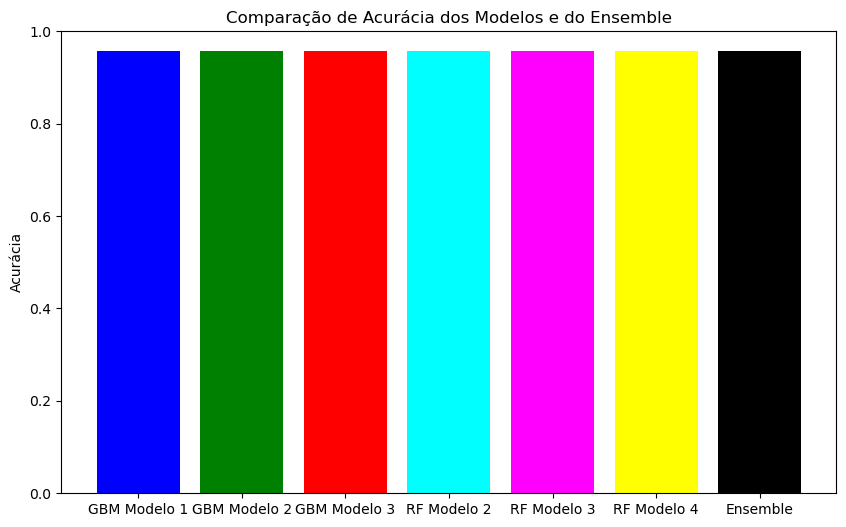

In [61]:
from sklearn.ensemble import VotingClassifier

# Combine os modelos GBM e Random Forest em um ensemble personalizado
ensemble_model = VotingClassifier(
    estimators=[
        ('gbm1', gbm_model_1),
        ('gbm2', gbm_model_2),
        ('gbm3', gbm_model_3),
        ('rf2', rf_model_2),
        ('rf3', rf_model_3),
        ('rf4', rf_model_4)
    ],
    voting='hard' 
)

# Treinar o modelo ensemble
ensemble_model.fit(X_train, y_train)

# Avaliar o modelo ensemble
y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
classification_rep_ensemble = classification_report(y_test, y_pred_ensemble)

print(f"Acurácia (Ensemble): {accuracy_ensemble * 100:.2f}%")
print("Relatório de Classificação (Ensemble):\n", classification_rep_ensemble)

# Comparação das Acurácias
plt.figure(figsize=(10, 6))
plt.bar(['GBM Modelo 1', 'GBM Modelo 2', 'GBM Modelo 3', 'RF Modelo 2', 'RF Modelo 3', 'RF Modelo 4', 'Ensemble'], 
        [accuracy_gbm_1, accuracy_gbm_2, accuracy_gbm_3, accuracy_rf_2, accuracy_rf_3, accuracy_rf_4, accuracy_ensemble], 
        color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple'])
plt.title('Comparação de Acurácia dos Modelos e do Ensemble')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()


# Conclusão

Os modelos analisados, incluindo Gradient Boosting Machine (GBM), Random Forest (RF), Árvores de Decisão, k-Nearest Neighbors (kNN), e o modelo de ensemble, demonstraram um desempenho robusto, com cada um apresentando pontos fortes e áreas de melhoria.

   - GBM e RF mostraram excelente capacidade de prever corretamente as classificações, com destaque para a alta precisão, especialmente na identificação de casos True. No entanto, o recall da classe True sugere que há margem para melhorias.
   - Árvores de Decisão variaram em desempenho, com alguns modelos mostrando excelente recall para a classe True, mas precisando de melhorias na identificação da classe False.
   - kNN teve desafios com o recall da classe True, apesar da precisão ser alta. Este modelo pode se beneficiar de um ajuste mais fino dos parâmetros.
   - O ensemble, combinando múltiplas abordagens, conseguiu capitalizar sobre os pontos fortes de cada modelo individual, resultando em um sistema robusto e eficaz, embora ainda com espaço para otimização no recall da classe True.
   
## Próximos passos

Para próximos passos do estudo, podemos considerar:

1. Ajuste de Parâmetros: Continuar a ajustar os parâmetros dos modelos individuais e do ensemble para encontrar um equilíbrio melhor entre precisão e recall, particularmente focando no aumento do recall para a classe True.

2. Exploração de Técnicas de Rebalanceamento de Classes: Implementar técnicas avançadas de rebalanceamento, como SMOTE, para os modelos que têm dificuldade com a classe minoritária.

3. Análise e Seleção de Features: Investigar as features utilizadas nos modelos para garantir que são as mais impactantes. Considerar a engenharia de novas features que possam melhorar a distinção entre as classes.

4. Experimentação com Métricas de Distância (kNN): Testar diferentes métricas de distância além das Euclidean e Manhattan, como Minkowski ou Chebyshev, para verificar se melhoram o desempenho do kNN.

5. Validação Cruzada Rigorosa: Utilizar técnicas de validação cruzada para testar a robustez dos ajustes de modelos em diferentes subconjuntos de dados, assegurando a generalização e a redução de overfitting.